In [17]:
pip install rtree
pip install git+https://github.com/mikedh/trimesh.git

   ---------------------------------------- 0.0/481.9 kB ? eta -:--:--
   --------- ------------------------------ 112.6/481.9 kB 3.3 MB/s eta 0:00:01
   ------------------------- -------------- 307.2/481.9 kB 3.8 MB/s eta 0:00:01
   ---------------------------------------  481.3/481.9 kB 3.8 MB/s eta 0:00:01
   ---------------------------------------- 481.9/481.9 kB 3.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Amount of all faces:  199
Maximum distance between the center and an outer wall face center: 7.777946018535457
Amount of outer wall faces:  164


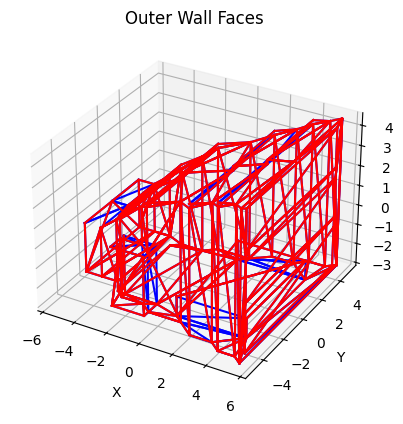

In [4]:
import sys
sys.path.append ('../ILDARSrevised')
import toml
import trimesh
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Read experiment setup from settings.toml file
settings_file = open("evaluation/settings.toml", "r")
settings = toml.load(settings_file)
# Read the selected room from the settings
selected_room = settings["simulation"]["room"]

# Define the directory where your 3D object files are stored
directory = "evaluation/testrooms/models/"

# Construct the file path for the selected room
file_path = directory + selected_room + ".obj"

# Load the 3D object using Trimesh
mesh = trimesh.load_mesh(file_path)

# Load the 3D object using Trimesh
#mesh = trimesh.load_mesh('evaluation/testrooms/models/pyramidroom.obj')

# Get all the faces of the mesh
faces = mesh.faces
print("Amount of all faces: ", len(faces))

# Calculate the centers of all faces
face_centers = mesh.vertices[faces].mean(axis=1)

# Cast rays from the origin to the face centers
ray_directions = -face_centers  # Direction towards the face centers from the origin
ray_directions /= np.linalg.norm(ray_directions, axis=1)[:, np.newaxis]  # Normalize directions

# Initialize an empty list to store the outer wall faces
outer_wall_faces = []

# Iterate over each face center and cast a ray towards it
for ray_direction, face_center in zip(ray_directions, face_centers):
    # Cast ray from the receiver towards the face center
    ray_origin = np.zeros(3)  # (0,0,0)
    ray_end = face_center
    result = mesh.ray.intersects_id([ray_origin], [ray_end])

    # If an intersection is found, add the intersected face to the list of outer wall faces
    if len(result) > 0:
        face_id = result[0][0]
        if face_id not in outer_wall_faces:
            outer_wall_faces.append(face_id)

max_distance_center_to_outer_wall_center = 0

# Calculate the center of the room
room_center = mesh.bounds.mean(axis=0)

# Iterate through each outer wall face
for face_id in outer_wall_faces:
    # Get the vertices of the face
    vertices = mesh.vertices[faces[face_id]]
    # Calculate the center of the face
    face_center = vertices.mean(axis=0)
    # Calculate the distance between the center of the room and the center of the face
    distance_center_to_outer_wall_center = np.linalg.norm(face_center - room_center)
    # Update the maximum distance if necessary
    max_distance_center_to_outer_wall_center = max(max_distance_center_to_outer_wall_center, distance_center_to_outer_wall_center)

print("Maximum distance between the center and an outer wall face center:", max_distance_center_to_outer_wall_center)


# Now, all faces in outer_wall_faces list are the outer wall faces
# Create a new figure for plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot all the faces
for face_id, face in enumerate(faces):
    vertices = mesh.vertices[face]
    ax.plot(vertices[:, 0], vertices[:, 1], vertices[:, 2], color='blue')

# Plot the outer wall faces in a different color
for face_id in outer_wall_faces:
    vertices = mesh.vertices[faces[face_id]]
    ax.plot(vertices[:, 0], vertices[:, 1], vertices[:, 2], color='red')
print("Amount of outer wall faces: ", len(outer_wall_faces))

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Outer Wall Faces')

# Show plot
plt.show()
